# To do:
Get 800 Locu menus

Parse the Foursquare menus

In [4]:
import requests
import os
import importlib
import pandas as pd
import numpy as np
%matplotlib inline
import pdb
import json
import time
import Kibbeh.src.feature_calc as feature_calc
import Kibbeh.src.API_io as API_io
import re
import matplotlib.pyplot as plt
import ast

In [5]:
working_dir = 'C:\\Users\\Chauncey\\Documents\\GitHub\\Kibbeh'
#working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\Kibbeh'
seattle_zips = pd.read_csv(working_dir + '\\seattle_zips.csv')['Zip'].values

In [6]:
# load foursquare menus
with open('fs_restaurant_menus.json', 'r') as json_file:
    fs_menus_rated = json.load( json_file)

In [4]:
# load yelp restaurants
with open('yelp_restaurant_list.json', 'r') as json_file:
    yelp_restos = json.load( json_file)

# Load Yelp data

In [85]:
from yelpapi import YelpAPI
with open(working_dir+ '\\yelp_api_key.txt', 'r') as api_file:
    api_key =  api_file.read()
    [CONSUMER_KEY, CONSUMER_SECRET, TOKEN, TOKEN_SECRET] = api_key.split('\n')
yelp_api = YelpAPI(CONSUMER_KEY, CONSUMER_SECRET, TOKEN, TOKEN_SECRET)

In [88]:
yelp_restos = API_io.get_yelp_restaurants(yelp_api)
len(yelp_restos)

1000

In [ ]:
# save
with open('yelp_restaurant_list.json', 'w') as json_file:
    json.dump(yelp_restos, json_file)

# Load Foursquare data
### Top restaurants in each zip code

In [84]:
# load pre-scraped data - this has lots of duplicates
with open('fs_restaurant_list.json', 'r') as json_file:
    fs_top_restos = json.load( json_file)
len(fs_top_restos)

3081

In [73]:
import foursquare
with open(working_dir+ '\\foursquare_api_key.txt', 'r') as api_file:
    api_key =  api_file.read()
    [FOURSQUARE_ID, FOURSQUARE_SECRET] = api_key.split('\n')
foursquare_client = foursquare.Foursquare(FOURSQUARE_ID, FOURSQUARE_SECRET)

In [76]:
# get data from all seattle zip codes
fs_top_restos = API_io.get_fs_top_restos_zip(foursquare_client, seattle_zips[:2])
# this takes a while to run
len(fs_top_restos)

Download data for 98001 zip code.
Download data for 98002 zip code.


156

In [81]:
fs_top_restos = remove_duplicate_fs_restos(fs_top_restos)
len(fs_top_restos)

3081

In [82]:
# save
with open('fs_restaurant_list.json', 'w') as json_file:
    json.dump(fs_top_restos, json_file)

### Random restaurants in a latitude longitude grid
Most of these do not have ratings or menus

In [ ]:
# not tested after offloading to API_io.py
seattle_grid = [-122.38, -122.28, 47.55, 47.70]
fs_ll_restos = API_io.get_fs_restos_by_ll(seattle_grid, foursquare_client, grid_step = 0.1)

In [ ]:
len(fs_ll_restos)

### Get menus from foursquare

In [93]:
# get foursquare venues that have both menu and rating
# use set intersection to get intersection of keys
fs_has_menu_rated = [x['venue'] for x in fs_top_restos if set(('menu', 'rating')) <= x['venue'].keys()]
len(fs_has_menu_rated)

1569

In [141]:
fs_menus_rated = API_io.get_menus_fs(foursquare_client,fs_id_list[:10])

In [131]:
# save menus
with open('fs_restaurant_menus.json', 'w') as json_file:
    json.dump(fs_menus_rated, json_file)

# Load OpenMenu data
Denied on OpenMenu API request

# Load Locu data
### Set up api key and class

In [97]:
from Kibbeh.src.locu_api import VenueApiClient, MenuItemApiClient
with open(working_dir+ '\\locu_api_key.txt', 'r') as api_file:
    api_key =  api_file.read()
    [LOCU_KEY] = api_key.split('\n')
venue_client = VenueApiClient(LOCU_KEY)

### Get list of locu restaurants by zip code

In [98]:
# load from local json
with open('locu_restaurant_list.json', 'r') as json_file:
    locu_restos = json.load( json_file)

In [70]:
import itertools
def get_locu_by_zip(venue_client, zip_list):
    # a set of 25 restaurants with menus for each zip code in seattle
    list_of_lists =  list(map(lambda x: venue_client.search(category=['restaurant'], has_menu=True, postal_code=x)['objects'],
                              zip_list) )
    return list(itertools.chain(*list_of_lists))

#venues = venue_client.search(locality = 'Seattle', has_menu=True)

In [49]:
locu_restos = get_locu_by_zip(venue_client, seattle_zips)
len(locu_restos)

1416

In [56]:
# save
with open('locu_restaurant_list.json', 'w') as json_file:
    json.dump(locu_restos, json_file)

### Search for menus of locations from yelp
To get yelp_df, need to execute feature_extraction below

In [95]:
import time
def get_menus_yelp(yelp_df, locu_restos, venue_client):
    ''' yelp_df is a dataframe with the 'name' as the index
        locu_restos is a json list of locu restaurant metadat '''
    
    new_locu_list = []
    menu_list = []
    
    # use phone number as unique index
    locu_phones = [x['phone'] for x in locu_restos ]
    locu_phones = list(map( lambda x: re.sub('[()\- ]', '',str(x)),  locu_phones) ) # get rid of punctuation
    
    # find menus for everything in yelp df
    for cur_resto in yelp_df.iterrows():
        try:
            # cur_resto[0] is the index / name, cur_resto[1] is the data
            if cur_resto[1]['phone'] in locu_phones:    # check if I have locu id for this restaurant
                cur_locu_id = locu_restos[ locu_phones.index(cur_resto[1]['phone']) ]['id']
                cur_menu = venue_client.get_menus(cur_locu_id)
            else:
                cur_locu = venue_client.search(name = cur_resto[0], locality='Seattle', category=['restaurant'], has_menu=True)
                time.sleep(0.5)
                if cur_locu['objects'] == []: # can't get a menu for this restaurant
                    continue
                new_locu_list.append(cur_locu['objects'][0])

                cur_menu = venue_client.get_menus( cur_locu['objects'][0]['id'] )

            menu_list.append( [cur_resto[0], cur_menu ] )
            time.sleep(0.5)
            #if cur_name
        except:
            print('Reached rate limit on restaurant: {0}'.format(cur_resto[0]))
            break
    return menu_list, new_locu_list

In [99]:
# looks like you can do ~1000 calls; stopped at 750
locu_yelp_overlap_menus2 = get_menus_yelp(yelp_df[750:], locu_restos, venue_client)

Reached rate limit on restaurant: Caffe Umbria


In [57]:

locu_menus = locu_yelp_overlap_menus[0]
#locu_menus.extend(locu_yelp_overlap_menus2[0])
#locu_menus.extend(locu_yelp_overlap_menus3[0])
len(locu_menus)

303

In [53]:
len(locu_yelp_overlap_menus[1])

92

In [55]:
locu_restos[-1].keys() == locu_restos[0].keys()

True

In [54]:
locu_restos.extend(locu_yelp_overlap_menus[1])

In [58]:
# save
with open('locu_menu_list.json', 'w') as json_file:
    json.dump(locu_menus, json_file)

# Feature extraction
## Yelp restaurants

In [9]:
yelp_df = feature_calc.feature_extract_yelp_list(yelp_restos)
yelp_df.head(3)

,categories,id,phone,rating,review_count
name,,,,,
Piroshky Piroshky,"[Bakeries, Russian]",piroshky-piroshky-seattle,2064416068,4.5,3235
Paseo,"[Caribbean, Cuban, Sandwiches]",paseo-seattle-3,2065457440,4.5,4099
Umma's Lunch Box,"[Korean, Buffets]",ummas-lunch-box-seattle,2068543166,4.5,184


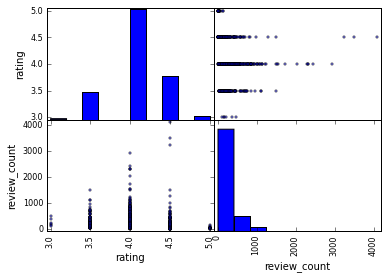

In [12]:
pd.scatter_matrix(ganma);

In [10]:
with open(working_dir + 'yelp_df.csv', 'w', encoding='utf8') as csv_file:
    yelp_df.to_csv(csv_file,  sep=';')

In [12]:
with open(working_dir + 'yelp_df.csv', 'r', encoding='utf8') as csv_file:
    yelp_df = pd.read_csv(csv_file, sep=';', index_col='name', dtype={'phone':str})
    yelp_df['categories'] = yelp_df['categories'].apply(ast.literal_eval )

NameError: name 'ast' is not defined

## Foursquare restaurant feature extraction

In [6]:
fs_rated = [x for x in fs_top_restos if 'rating' in x['venue'].keys()]
len(fs_rated)

7021

In [18]:
importlib.reload(feature_calc)
fs_df = feature_calc.feature_extract_fs_list(fs_rated)
fs_df.drop_duplicates(inplace=True)
fs_df.head(3)

,categories,checkinsCount,id,phone,rating,tier,tipCount,usersCount
name,,,,,,,,
Burger Express,Burgers,629,4c0c1f2d6071a593a954e232,2538742701,8.8,1,13,320
Señor Taco,Burritos,391,4b6a5e42f964a520a4d32be3,2536619915,8.7,1,12,138
Popeyes Louisiana Kitchen,Fried Chicken,470,4aeb5ad8f964a52050c121e3,2538749740,8.1,1,8,287


C:\Users\Chauncey\Anaconda3\lib\site-packages\pandas\tools\plotting.py:3235: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  "is being cleared", UserWarning)


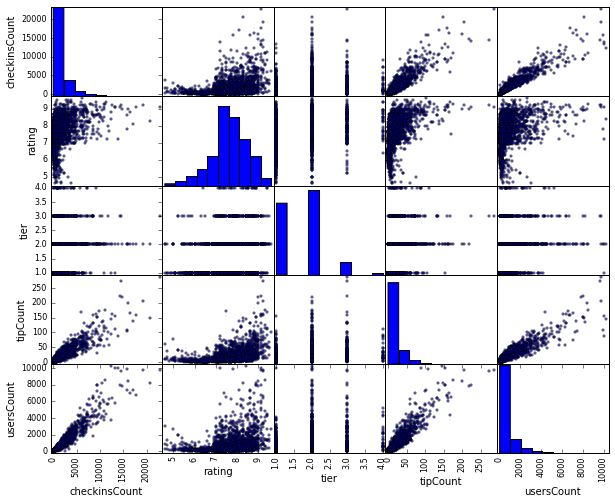

In [17]:
fig, fs_ax = plt.subplots(1, figsize=[10, 8])
pd.scatter_matrix(fs_df, ax=fs_ax);

## Foursquare menu feature extraction
Each menu json has keys: id, provider, menus

Each menus dict has keys: count (# of "menus"), and items (a LIST of menus, even if theree's just one)

Each element of items has keys: name (of menu), menuId, description, and entries (a dict)

Each entries has keys: count (# of items on menu), and list of items

Each element of items has keys: name, sectionId, description, and MORE entries

Each entries has keys: count, and a list of items

The FINAL items is a list, each element has: description, entryId, and name

In [19]:
import nltk
from nltk.corpus import stopwords

In [3]:
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

In [34]:
stop_words = set(stopwords.words('english'))
def wordify_json_menu(json_menu, stop_words):
    dumb_keys = {'name', 'count', 'items', 'Main', 'Menu', 'description', 'entries'}
    cur_menu = json_menu['menus']
    string_menu = json.dumps(cur_menu)
    letters_only_menu =re.sub("[^a-zA-Z]", " ", string_menu )
    menu_words = letters_only_menu.split() # split into words
    menu_words = [w for w in menu_words if len(w) > 2] # get rid of 1-2 letter words
    menu_words = [w for w in menu_words if w not in stop_words]
    menu_words = [w for w in menu_words if w not in dumb_keys]
    return ' '.join(menu_words).lower()

In [36]:
parsed_menus  = [wordify_json_menu(menu, stop_words) for menu in fs_menus_rated ] 

In [37]:
parsed_menus[0]

'menuid pwth knbki bonafide chicken sectionid louisiana tenders entryid whether spicy mild bonafide chicken marinated least hours hand battered hand breaded bursting bold louisiana flavor spicy entryid our freshly prepared bonafide chicken marinated popeyes spicy chicken marinade hand battered breaded uniquely southern crispy coating round one signature sides hot buttery biscuit mild entryid our freshly prepared bonafide chicken marinated louisiana seasonings hand battered breaded uniquely southern crispy coating round one signature sides hot buttery biscuit all bonafide chicken items available entryid combos entryid make combo includes signature side hot buttery biscuit ice cold refreshing drink family meals entryid feeding whole family get family meal pieces juicy bonafide chicken plus signature sides hot buttery biscuits get chicken spicy mild mix match kids chicken leg meal entryid one mild chicken leg regular fry small drink tenders our whole breast meat tenders slow marinated uni